# Barren plateaus and ansatz entanglement structures in Quantum Machine Learning

Barren plateaus are a phenomenon in the gradient-based training of quantum variational circuits whereby the training landscape for the parameters of the circuit is flat, and this can be observed as an exponential decrease in the variance of the gradients as a function of the number of qubits in the circuit.

In this notebook, different Variational Quantum Classifiers using the four different entanglement schemes (Linear, Full, Circular, SCA) in the qiskit module are trained on generated datasets from sklearn. The variance of the gradients calculated during the training of these classifiers are compared, and the von Neumann entropy of entanglement for each circuit is also tracked over the training of the models.

In [1]:
import qiskit
from qiskit import Aer, execute
from qiskit.quantum_info import entropy, Statevector, DensityMatrix
from qiskit.utils import QuantumInstance

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from qutip import Qobj

import numpy as np
import pandas as pd
import itertools
import joblib
import timeit

## Create the datasets to be used by the VQCs.

Define the settings for the number of qubits and number of reps. Each of the circuits that are created will use some combination of these values for the corresponding settings.

In [2]:
num_qubits = [3,4,5,6,7]
num_reps = [1,5,10,15]

Create and process the various datasets.

In [3]:
datasets = {}

for n in num_qubits:
    # create the dataset
    X, y = make_blobs(n_features=n,centers=2)
    # standardize the data
    X_s = StandardScaler().fit_transform(X)
    
    # change the labels from {0, 1} to {-1, 1}
    y = 2 * y - 1
    
    datasets[n] = [X_s, y]

Save the datasets so that they may be reused.

In [4]:
joblib.dump(datasets, './Datasets/datasets.txt')

['./Datasets/datasets.txt']

## Create the configurations from which the various Parameterized Quantum Circuits will be generated.

The configurations contain settings for the number of qubits, the entanglement scheme used in the ansatz, the number of reps of the ansatz, and the dataset whose dimensionality matches the input dimension of the circuit.

In [5]:
entanglement_modes = ['linear','full','circular','sca']

list_of_config_tuples = list(itertools.product(entanglement_modes, num_qubits, num_reps))

# assign each config its matching dataset
configs = []
for c in list_of_config_tuples:
    config = list(c)
    config.append(datasets[c[1]])
    configs.append(config)

print('Config 1:\nEntanglement Mode: ',configs[0][0],' | Num qubits: ',configs[0][1],' | Num reps: ',configs[0][2])

Config 1:
Entanglement Mode:  linear  | Num qubits:  3  | Num reps:  1


## Create and train the Neural Network classifier using the configurations generated

Using the configurations, create the Variational circuits, the Quantum Neural Networks, and the Neural Network Classifiers to be trained using the generated datasets.

An example of the feature map and ansatz, as well as the circuit built with them:

Feature map for Config 1:


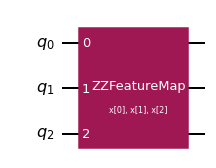

In [6]:
from qiskit.circuit.library import ZZFeatureMap, EfficientSU2

feature_map_example = ZZFeatureMap(configs[0][1],reps=1)
print('Feature map for Config 1:')
feature_map_example.draw('mpl',style='iqx')

Ansatz for Config 1:


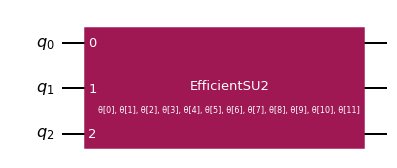

In [7]:
ansatz_example = EfficientSU2(num_qubits=configs[0][1],entanglement=configs[0][0],reps=configs[0][2])
print('Ansatz for Config 1:')
ansatz_example.draw('mpl',style='iqx')

Thus, the variational circuit for Config 1:


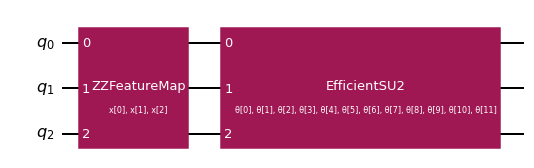

In [8]:
circuit_example = feature_map_example.compose(ansatz_example)
print('Thus, the variational circuit for Config 1:')
circuit_example.draw('mpl',style='iqx')

The AlteredADAM class contains a version of the gradient-based ADAM optimizer which has been altered so that it records and returns the gradients that are calculated in each training epoch. It also contains the TrackingResult class, which provides a convenient container for all of the information of interest in the use_config call.

In [9]:
from AlteredADAM import *

qiskit.utils.algorithm_globals.random_seed = 14     # set the random seed so that the behaviour of the optimizer is reproducible

The method below creates the variational circuit, uses this to generate the quantum neural network, and then creates the Neural Network Classifier, which it trains using the configuration's dataset.

In [10]:
from qiskit.opflow import Gradient, StateFn, PauliExpectation, Z, I

from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier

def use_config(config, q_instance):
    # this directory is given to the optimizer to store the parameters at each iteration
    params_csv = './Parameters/'+config[0]+'/'+str(config[1])+' qubits/'+str(config[2])+' reps'
    
    # create the feature map
    feature_map = ZZFeatureMap(config[1],reps=1)
    # create the ansatz
    ansatz = EfficientSU2(num_qubits=config[1],entanglement=config[0],reps=config[2])
    # create the variational circuit
    circuit = feature_map.compose(ansatz)
    
    # define the local operator for the expectation values
    hamiltonian = Z ^ Z ^(I ^ (config[1]-2))
    
    expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)
    
    # create the quantum neural network
    qnn = OpflowQNN(expectation,
                    input_params=list(feature_map.parameters),
                    weight_params=list(ansatz.parameters),
                    exp_val=PauliExpectation(),
                    gradient=Gradient(),
                    quantum_instance=q_instance)
    
    # the classical optimizer which will update the parameters of the circuit in the training process
    optimizer = AlteredADAM(maxiter=50,snapshot_dir=params_csv)
    
    # create the neural network classifier using the qnn
    classifier = NeuralNetworkClassifier(qnn,optimizer=optimizer)
    
    # time the training of the classifier
    start = timeit.default_timer()
    
    # train the optimizer on the training data
    classifier.fit(config[3][0],config[3][1])
    
    elapsed = timeit.default_timer() - start
    
    # create the tracking object for this classifier
    tracking_object = TrackingResult(config[1],config[2],config[0],classifier._fit_result[3],params_csv)
    
    # save the tracking object
    file = './Results/Without Entropy/'+config[0]+'/'+str(config[1])+' qubits and '+str(config[2])+' reps.txt'
    joblib.dump(tracking_object,file)
    
    print('Done with config: ',config[0],' with ',str(config[1]),' qubits and ',str(config[2]),' reps')
    print('Time taken: ',elapsed,' seconds\n')

## Create and train the classifiers for each configuration

This code may take days to run.

In [11]:
# create the backend and quantum instance on which the circuits will run
backend = Aer.get_backend('statevector_simulator')
q_instance = QuantumInstance(backend, shots=1)

# this will run using 28 threads. Adjust this number accordingly to suit your CPU
parallel_pool = joblib.Parallel(n_jobs=28)      

# use the configs in parallel
#parallel_pool(joblib.delayed(use_config)(c, q_instance) for c in configs)

## Calculate the von Neumann Entropy of Entanglement at each training epoch for the Classifiers.


In [12]:
# this method processes the parameters so that they may easily be assigned to the circuits
def get_data_dict(params, x, ansatz, feature_map):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = x[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = params[i]
    return parameters

In [13]:
# this method returns the correct dims for the Qobj object, which is important for the partial trace
def dims(num_qubits):
    rows=[]
    cols=[]
    for i in range(num_qubits):
        rows.append(2)
        cols.append(1)
    return [rows, cols]

The method below calculates the entropy at each epoch for a given configuration. This method uses the parameters stored in the adam_params.csv files, and so this method must only be called after the classifiers have been trained.

The initial state of the system is $$ |0\rangle^{\otimes n} $$ where n is the number of qubits in the circuit. The parameters are assigned to the circuit, and then the initial state is evolved by the variational circuit and the final statevector is obtained.

Then the partial density matrix is obtained by using a partial trace to trace out a bi-partition of qubits from the system, and the entropy is calculated using this partial density matrix. This is done for all possible bi-partitions, and the average entroy of entanglement is returned. 

In [14]:
backend = Aer.get_backend('statevector_simulator')

def calculate_entropy(config):

    entanglement_mode = config[0]
    num_qubits = config[1]
    num_reps = config[2]
    dataset = config[3]
    training_data = dataset[0]
    
    # load the tracking result object for the config from its file
    result_path = './Results/Without Entropy/' + entanglement_mode + "/" + str(num_qubits) + " qubits and " + str(num_reps) + " reps.txt"
    tracking_object = joblib.load(result_path)
    
    # load the data from the parameters file
    parameter_csv = tracking_object.params_file + '/adam_params.csv'
    df = pd.read_csv(parameter_csv, usecols=['m'])
    
    # process the file and obtain a list of parameter sets
    arr = df.to_numpy()
    param_array = []
    for i in arr:
        a_list = i[0].rstrip(']').lstrip('[').split()
        map_object = map(float, a_list)
        list_of_integers = list(map_object)
        param_array.append(list_of_integers)

    # recreate circuit used in the classifier
    feature_map = ZZFeatureMap(num_qubits, reps=1)
    ansatz = EfficientSU2(num_qubits=num_qubits, entanglement=entanglement_mode,
                          reps=num_reps)
    circuit = feature_map.compose(ansatz)

    # obtain the partitions that will be traced out of the density matrix
    qubits = [x for x in range(num_qubits)]
    combinations = itertools.combinations(qubits, 2)
    partitions = []

    for c in combinations:
        partitions.append(c)

    # calculate the entropy for each training epoch using the stored parameters
    vn_entropy = []
    for p in param_array:

        vN = 0
        
        # the initial state of the system
        state_vector = Statevector.from_label('0' * num_qubits)
            
        circ_ = circuit.assign_parameters(get_data_dict(p, training_data[0], ansatz, feature_map))

        # evolve the initial statevector by the circuit
        qc = state_vector.evolve(circ_)

        # execute the circuit 50 times and obtain the final statevector
        ckt_state = execute(circ_, backend, shots=50).result().get_statevector()

        for part in partitions:

            # create a Quantum Object from the statevector
            stateV = Qobj(ckt_state, dims=dims(num_qubits))
            partialDensityMatrix = stateV.ptrace([x for x in qubits if x not in part])
            dM = DensityMatrix(partialDensityMatrix.full())
            vN += entropy(dM) / len(partitions)

        vn_entropy.append(vN)
    
    # store the list of entropies in the tracking result objects respective attribute
    tracking_object.entropies = vn_entropy

    # save the now complete tracking result object
    final_path = './Results/With Entropy/' + entanglement_mode + "/" + str(num_qubits) + " qubits and " + str(num_reps) + " reps.txt"
    joblib.dump(tracking_object, final_path)

Calculate the entropy of entanglement of each training epoch for each configuration.

In [15]:
#parallel_pool(joblib.delayed(calculate_entropy)(c) for c in configs)

# Variance of Gradients as a function of Number of Qubits

Now that the Neural Network classifiers for each configuration have been trained, the training gradients have been stored, and the von Neumann entropy of entanglement at each training epoch has been calculated, we can plot the results.

In [16]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def plot_gradients(results, num_qubits, num_reps, entanglement):
    
    plt.figure(figsize=(12,6))
    fitted_lines = []
    
    for r in range(len(results)):
        
        if r == 0:
            reps = 1
        else:
            reps = r*5
        
        label_string = str(reps)+' layers'
        plt.semilogy(num_qubits, np.var(results[r], axis=1), 'o-', label=label_string)
        plt.legend(loc='best', fontsize='x-small')

        fit = np.polyfit(num_qubits, np.log(np.var(results[r], axis=1)), deg=1)
        x = np.linspace(num_qubits[0], num_qubits[-1], 200)

        fitted_lines.append([fit, x])

        plt.title(entanglement + " Entanglement")
        plt.xlabel('Number of qubits')
        plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
        plt.legend(loc='best', fontsize='x-small')
    
    min_index = 0
    min_fit = 0

    for i in range(len(fitted_lines)):
        f = fitted_lines[i][0]
        value = f[0]
        if value <= min_fit:
            min_fit = value
            min_index = i
    
    # fit the steepest line
    plt.semilogy(x, np.exp(fitted_lines[min_index][0][0] * x + fitted_lines[min_index][0][1]), 'r--', label=f'exponential fit w/ {fitted_lines[min_index][0][0]:.2f}')
    plt.legend(loc='best', fontsize='x-small')
    plt.show()

Read the tracking result objects from their files, then process and plot them.

In [17]:
modes = ['linear','full','circular','sca']
num_qubits = [3,4,5,6,7]
num_reps = [1,5,10,15]

results = {}
for m in entanglement_modes:
    
    mode_results = []
    for r in num_reps:
        
        set_depth = []
        for n in num_qubits:
            # read the objects from their files
            file = './Results/With Entropy/' + m + '/' + str(n) + ' qubits and ' + str(r) + ' reps.txt'
            tracking_object = joblib.load(file)
            set_depth.append(tracking_object.gradients)

        mode_results.append(set_depth)

    results[m] = mode_results

## Using the Linear Entanglement scheme for the ansatz.

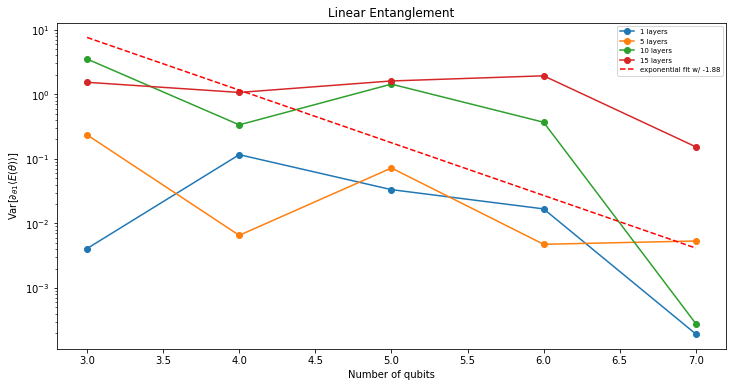

In [18]:
# plot the Linear Entanglement Gradient Results
plot_gradients(results['linear'],num_qubits,num_reps,'Linear')

## Using the Full Entanglement scheme for the ansatz.

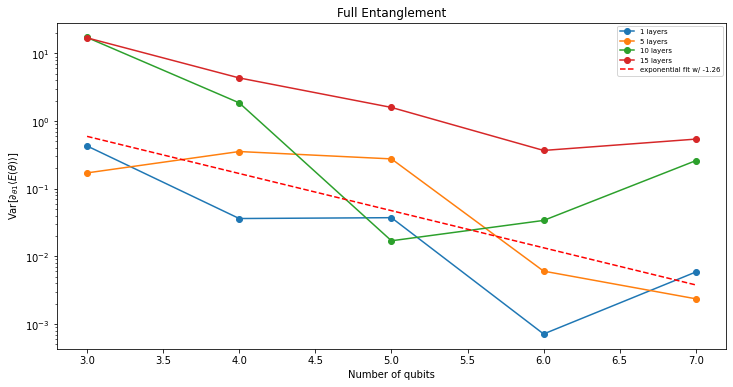

In [19]:
# plot the Full Entanglement Gradient Results
plot_gradients(results['full'],num_qubits,num_reps,'Full')

## Using the Circular Entanglement scheme for the ansatz.

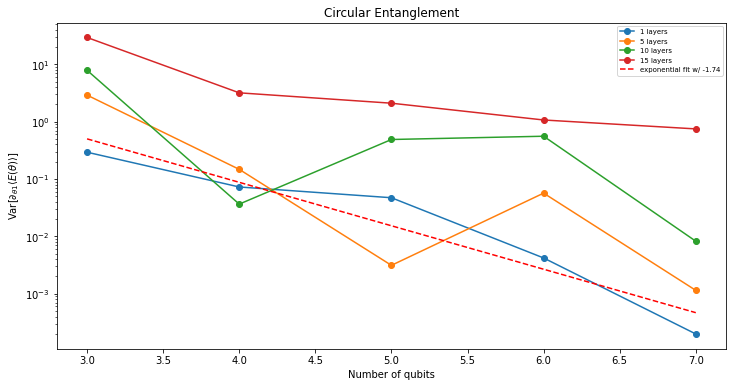

In [20]:
# plot the Circular Entanglement Gradient Results
plot_gradients(results['circular'],num_qubits,num_reps,'Circular')

## Using the SCA Entanglement scheme for the ansatz.

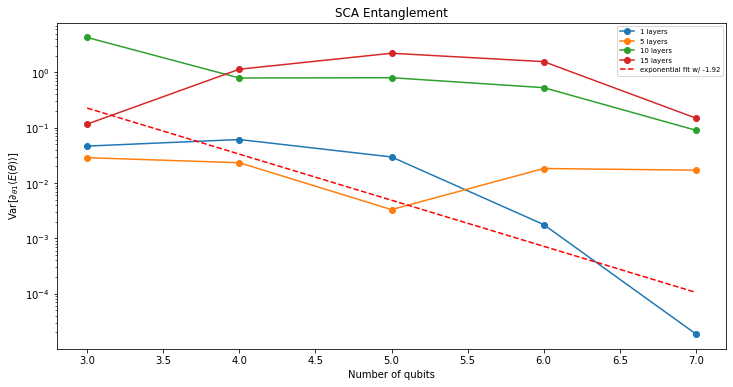

In [21]:
# plot the SCA Entanglement Gradient Results
plot_gradients(results['sca'],num_qubits,num_reps,'SCA')

# The von Neumann Entropy of Entanglement for each training epoch

Next we can plot the entropies of entanglement.

In [22]:
def plot_entropies(results):

    epochs = [x for x in range(len(results[0].entropies))]
    plt.figure(figsize=(12,6))
    
    for r in results:
        
        entanglement = r.entanglement.capitalize()

        label_string = str(r.num_qubits) + ' qubits, ' + str(r.num_reps) + ' layers'
        plt.plot(epochs, r.entropies, label=label_string)
        plt.legend(loc='best', fontsize='x-small')

        plt.title(entanglement.capitalize() + " Entanglement")
        plt.xlabel('Training Epochs')
        plt.ylabel('von Neumann Entropy of Entanglement')
        plt.legend(loc='best', fontsize='x-small')

    plt.show()

In [23]:
results = {}

for m in modes:
    
    same_qubit_circuits = {3:[], 4:[], 5:[], 6:[], 7:[]}
    
    for r in num_reps:
        for n in num_qubits:
            
            file = './Results/With Entropy/' + m + '/' + str(n) + ' qubits and ' + str(r) + ' reps.txt'

            tracking_object = joblib.load(file)
            same_qubit_circuits[tracking_object.num_qubits].append(tracking_object)
    
    results[m] = same_qubit_circuits

## Entropy measures for the circuits using 3 qubits.

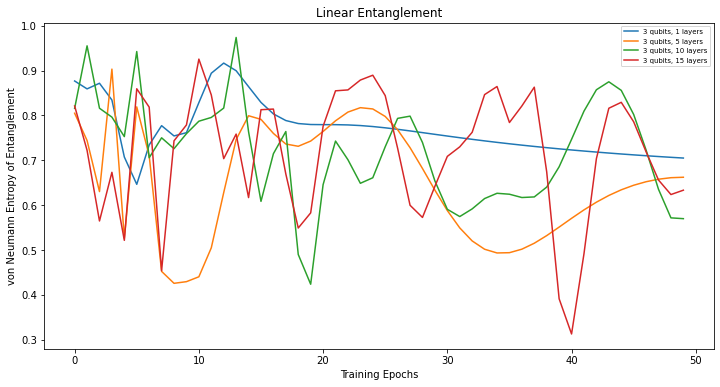

In [24]:
# plot the vN entropies for the Linear Entanglement with 3 qubits
plot_entropies(results['linear'][3])

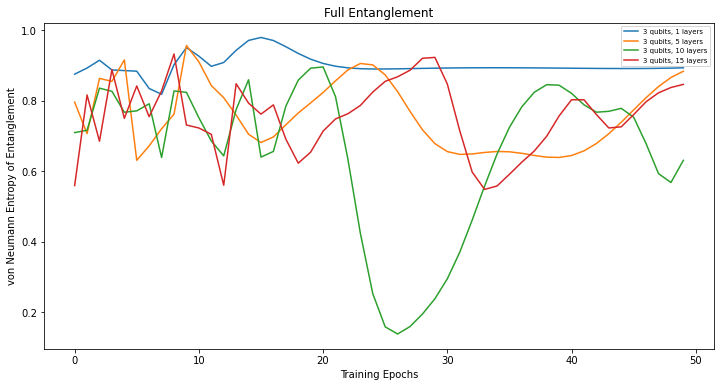

In [25]:
# plot the vN entropies for the Full Entanglement with 3 qubits
plot_entropies(results['full'][3])

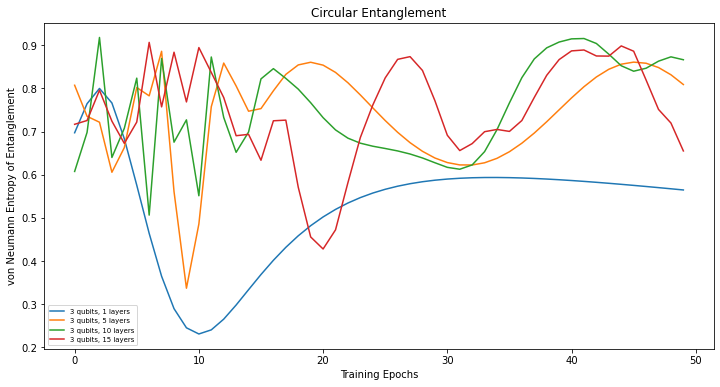

In [26]:
# plot the vN entropies for the Circular Entanglement with 3 qubits
plot_entropies(results['circular'][3])

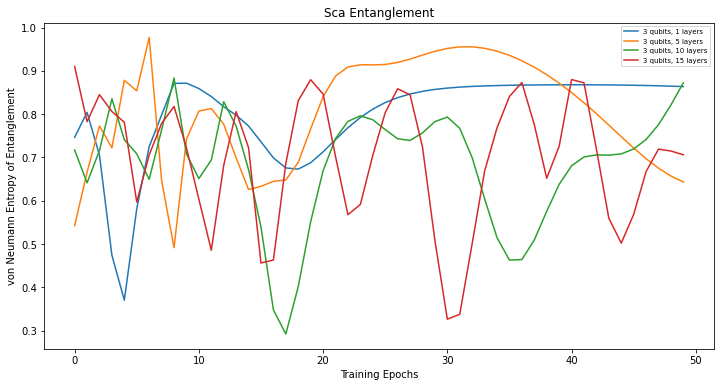

In [27]:
# plot the vN entropies for the SCA Entanglement with 3 qubits
plot_entropies(results['sca'][3])

## Entropy measures for the circuits using 4 qubits.

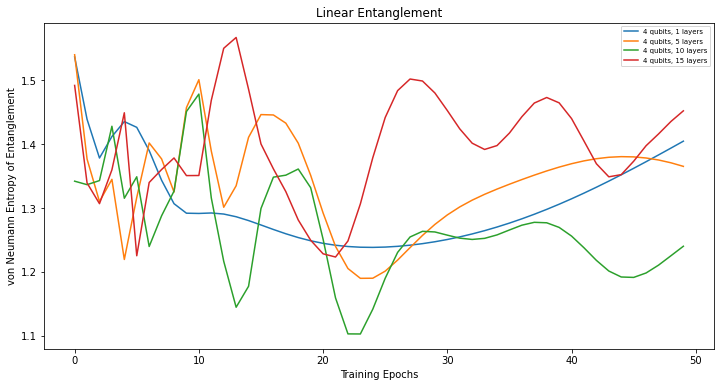

In [28]:
# plot the vN entropies for the Linear Entanglement with 4 qubits
plot_entropies(results['linear'][4])

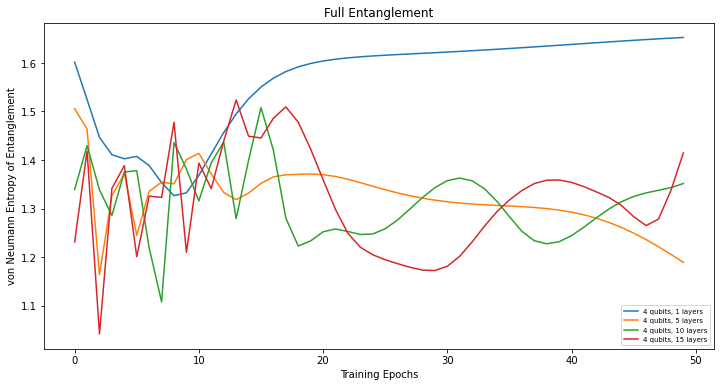

In [29]:
# plot the vN entropies for the Full Entanglement with 4 qubits
plot_entropies(results['full'][4])

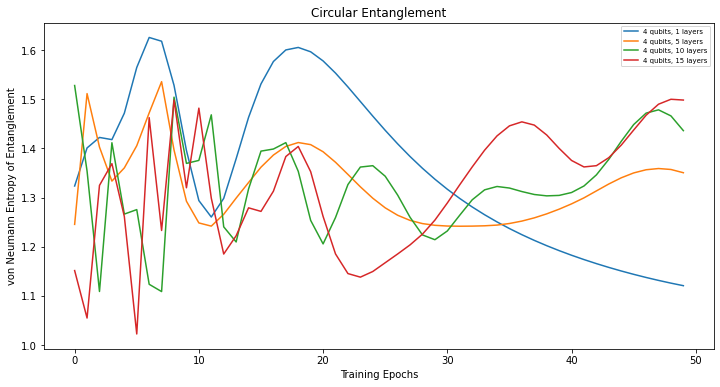

In [30]:
# plot the vN entropies for the Circular Entanglement with 4 qubits
plot_entropies(results['circular'][4])

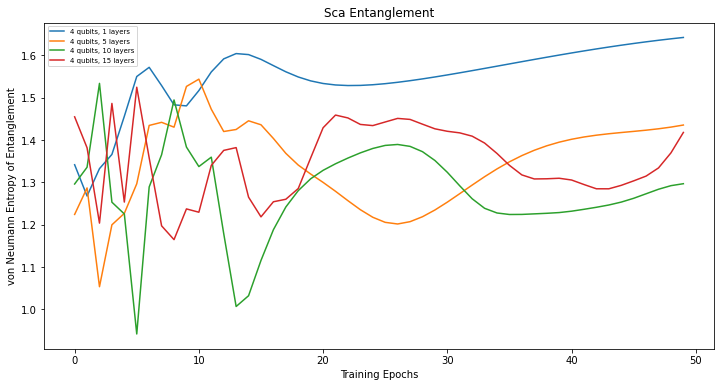

In [31]:
# plot the vN entropies for the SCA Entanglement with 4 qubits
plot_entropies(results['sca'][4])

## Entropy measures for the circuits using 5 qubits.

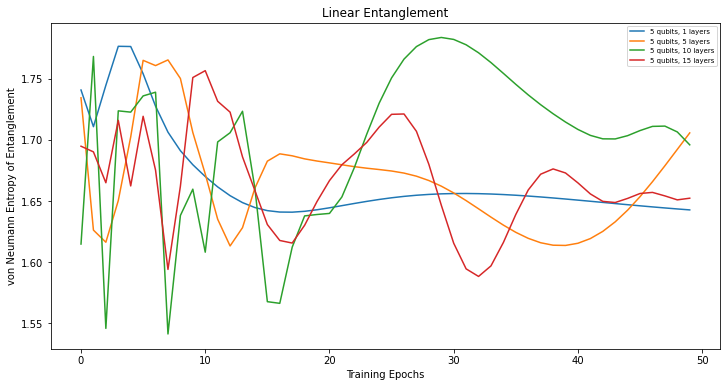

In [32]:
# plot the vN entropies for the Linear Entanglement with 5 qubits
plot_entropies(results['linear'][5])

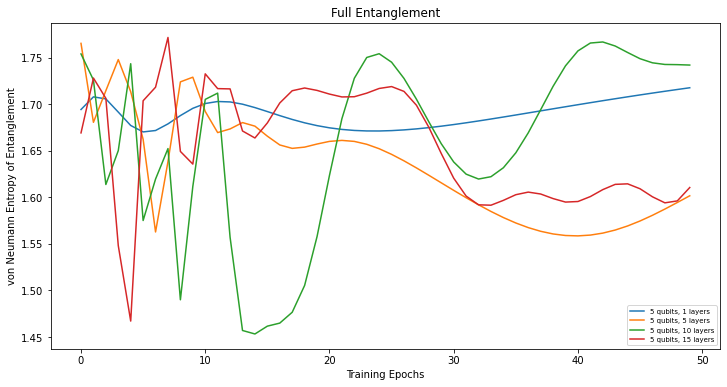

In [33]:
# plot the vN entropies for the Full Entanglement with 5 qubits
plot_entropies(results['full'][5])

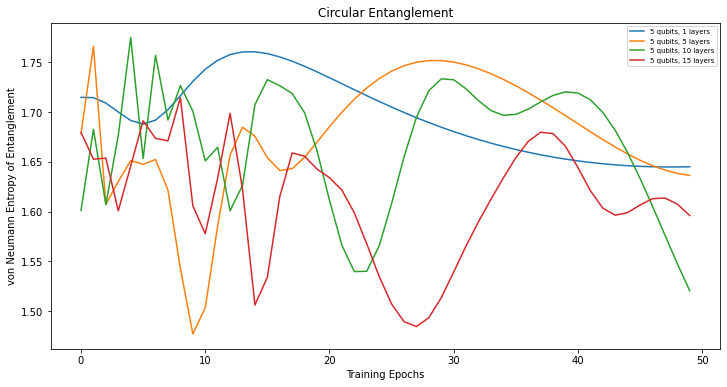

In [34]:
# plot the vN entropies for the Circular Entanglement with 5 qubits
plot_entropies(results['circular'][5])

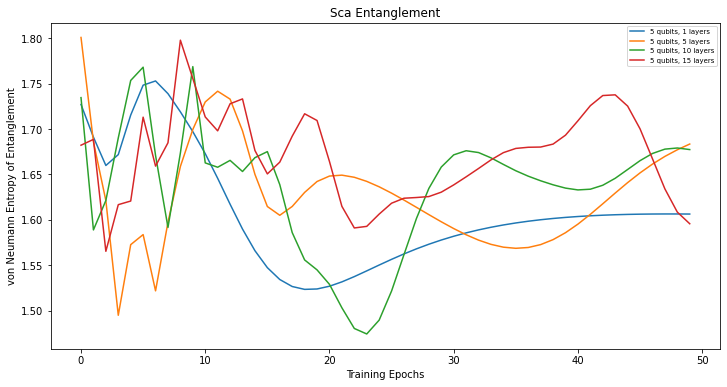

In [35]:
# plot the vN entropies for the SCA Entanglement with 5 qubits
plot_entropies(results['sca'][5])

## Entropy measures for the circuits using 6 qubits.

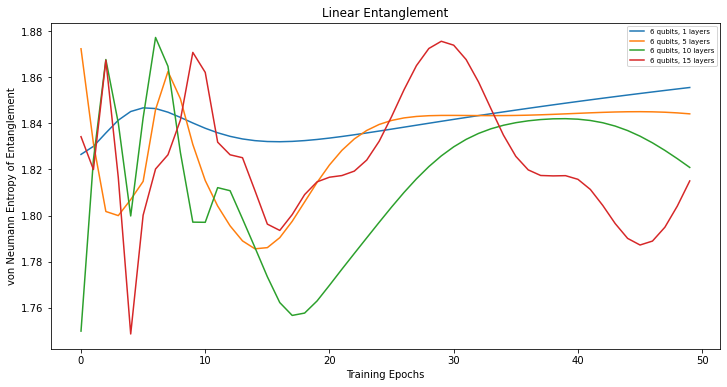

In [36]:
# plot the vN entropies for the Linear Entanglement with 6 qubits
plot_entropies(results['linear'][6])

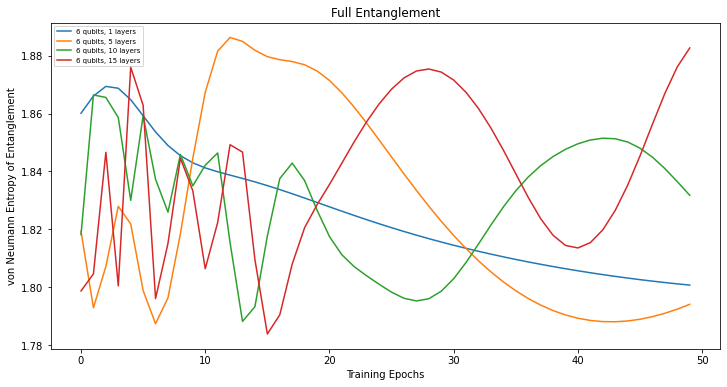

In [37]:
# plot the vN entropies for the Full Entanglement with 6 qubits
plot_entropies(results['full'][6])

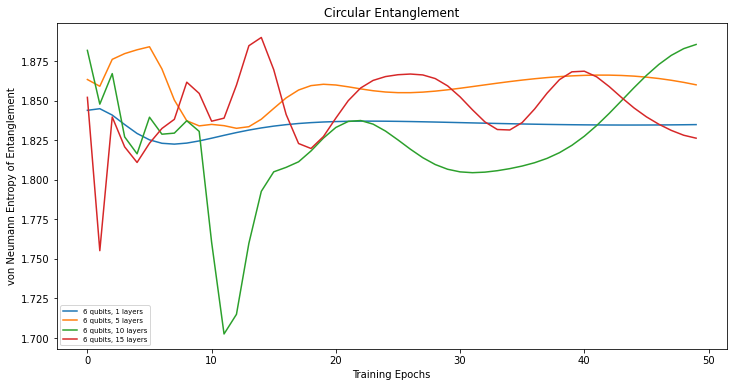

In [38]:
# plot the vN entropies for the Circular Entanglement with 6 qubits
plot_entropies(results['circular'][6])

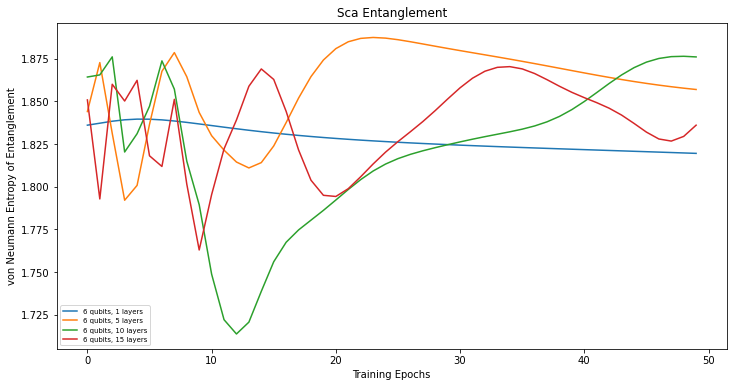

In [39]:
# plot the vN entropies for the SCA Entanglement with 6 qubits
plot_entropies(results['sca'][6])

## Entropy measures for the circuits using 7 qubits.

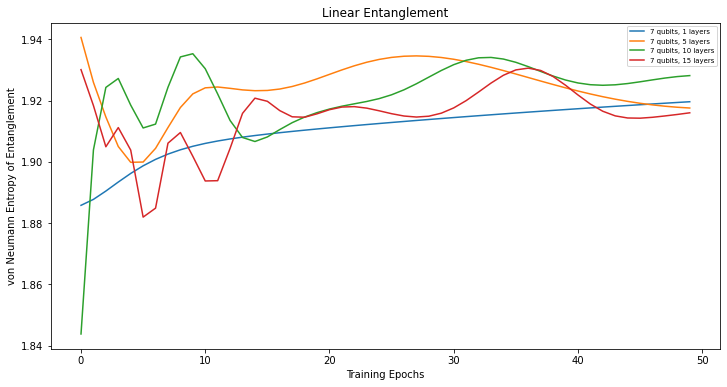

In [40]:
# plot the vN entropies for the Linear Entanglement with 7 qubits
plot_entropies(results['linear'][7])

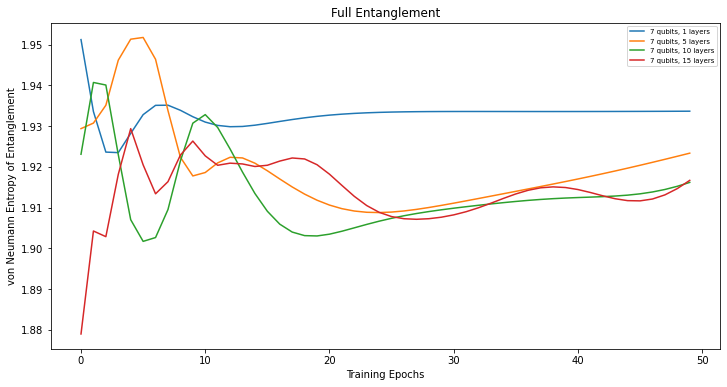

In [41]:
# plot the vN entropies for the Full Entanglement with 7 qubits
plot_entropies(results['full'][7])

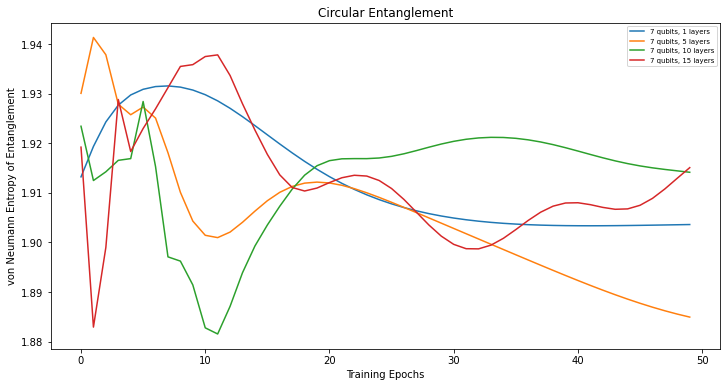

In [42]:
# plot the vN entropies for the Circular Entanglement with 7 qubits
plot_entropies(results['circular'][7])

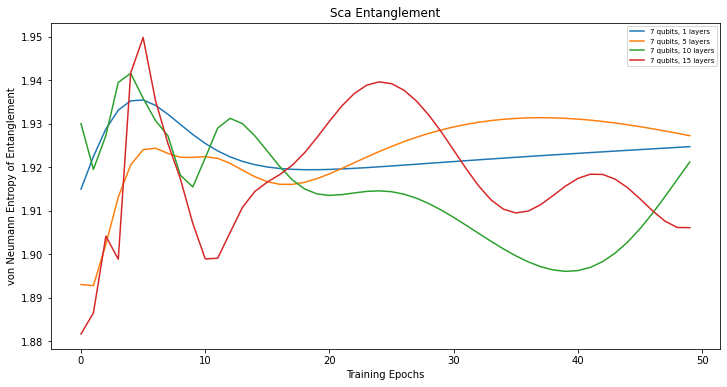

In [45]:
# plot the vN entropies for the SCA Entanglement with 7 qubits
plot_entropies(results['sca'][7])